In [1]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
  !pip install muon
  !pip install mudatasets

# Data structures for single-cell and multi-modal data

## AnnData

AnnData is a data matrix with some metadata. To demonstrate basic usage, we first import relevant Python packages and then create an AnnData object with random data.

In [2]:
import anndata
import numpy as np
from scipy.sparse import csr_matrix

# Simulate a sparse count matrix with 100 rows and 2000 columns
counts = csr_matrix(np.random.poisson(1, size=(100, 2000)))
adata = anndata.AnnData(counts, dtype=np.float32)
adata

AnnData object with n_obs × n_vars = 100 × 2000

The `.X` attribute contains the data. In our case, this is a sparse matrix.

In [3]:
adata.X

<100x2000 sparse matrix of type '<class 'numpy.float32'>'
	with 126562 stored elements in Compressed Sparse Row format>

Our AnnData object does not have any metadata yet. We can assign names to observations (cells) and variables (genes).

In [4]:
adata.obs_names = [f"Cell_{i}" for i in range(adata.n_obs)]
adata.var_names = [f"Gene_{i}" for i in range(adata.n_vars)]
adata.obs_names

Index(['Cell_0', 'Cell_1', 'Cell_2', 'Cell_3', 'Cell_4', 'Cell_5', 'Cell_6',
       'Cell_7', 'Cell_8', 'Cell_9', 'Cell_10', 'Cell_11', 'Cell_12',
       'Cell_13', 'Cell_14', 'Cell_15', 'Cell_16', 'Cell_17', 'Cell_18',
       'Cell_19', 'Cell_20', 'Cell_21', 'Cell_22', 'Cell_23', 'Cell_24',
       'Cell_25', 'Cell_26', 'Cell_27', 'Cell_28', 'Cell_29', 'Cell_30',
       'Cell_31', 'Cell_32', 'Cell_33', 'Cell_34', 'Cell_35', 'Cell_36',
       'Cell_37', 'Cell_38', 'Cell_39', 'Cell_40', 'Cell_41', 'Cell_42',
       'Cell_43', 'Cell_44', 'Cell_45', 'Cell_46', 'Cell_47', 'Cell_48',
       'Cell_49', 'Cell_50', 'Cell_51', 'Cell_52', 'Cell_53', 'Cell_54',
       'Cell_55', 'Cell_56', 'Cell_57', 'Cell_58', 'Cell_59', 'Cell_60',
       'Cell_61', 'Cell_62', 'Cell_63', 'Cell_64', 'Cell_65', 'Cell_66',
       'Cell_67', 'Cell_68', 'Cell_69', 'Cell_70', 'Cell_71', 'Cell_72',
       'Cell_73', 'Cell_74', 'Cell_75', 'Cell_76', 'Cell_77', 'Cell_78',
       'Cell_79', 'Cell_80', 'Cell_81', 'Cell_82',

Now we can subset the AnnData object using cell and gene names.

In [5]:
adata[["Cell_1", "Cell_10"], ["Gene_5", "Gene_1900"]]

View of AnnData object with n_obs × n_vars = 2 × 2

Note that we got a View of an AnnData object. The view does not store any data but points to the original AnnData object instead to save memory. The view will automatically convert itself to a full AnnData object by copying the relevant subset of the original object if we try to add some data to the view.

We can also add some metadata describing the observations. To demonstrate, we randomly assign one of three random cell types to a column in the `.obs` data frame.

In [6]:
adata.obs["cell_type"] = np.random.choice(["B", "T", "Monocyte"], size=(adata.n_obs,))
adata.obs

cell_type
Cell_0   Monocyte
Cell_1          T
Cell_2          T
Cell_3          B
Cell_4          T
...           ...
Cell_95  Monocyte
Cell_96  Monocyte
Cell_97         B
Cell_98         B
Cell_99  Monocyte

[100 rows x 1 columns]

Note that the description of the AnnData object now includes the new column.

In [7]:
adata

AnnData object with n_obs × n_vars = 100 × 2000
    obs: 'cell_type'

We can also subset the AnnData object using boolean indexing. For example, we can get all B cells.

In [8]:
bdata = adata[adata.obs.cell_type == "B"]
bdata

View of AnnData object with n_obs × n_vars = 36 × 2000
    obs: 'cell_type'

AnnData can store multiple data matrices. This is useful if one wants to keep both original and transformed, e.g. normalized, data. All matrices must have the same shape.

In [9]:
adata.layers["log_transformed"] = np.log1p(adata.X)
adata

AnnData object with n_obs × n_vars = 100 × 2000
    obs: 'cell_type'
    layers: 'log_transformed'

Try to add a new layer with the AnnData object with the reverse transformation. For the sparse matrix, we can use the `.expm1()` method. 

In [10]:
# Q: add adata.layers["counts"] with counts transformed back to their original values
# adata.layers["counts"] = ... adata.layers["log_transformed"] ...

In [11]:
# Q: inspect the resulted matrix. Is it different from the original counts in .X?
# You can use .toarray() to display the matrix in the dense format.

## MuData

MuData objects contain a dictionary of AnnData objects and are used for multimodal data. AnnData objects within a MuData container are aligned and can be jointly subsetted.

To demonstrate, we will use the `adata` and `bdata` objects from above. Since MuData assumes that variables are unique to each modality, we first change `bdata`'s variable names and then create a MuData object.

In [12]:
import mudata

In [13]:
bdata.var_names = [f"Protein_{i}" for i in range(bdata.n_vars)]
mdata = mudata.MuData({"rna": adata, "prot": bdata})
mdata

/home/max/miniconda3/envs/pdcstegle/lib/python3.10/site-packages/mudata/_core/mudata.py:578: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_mod.loc[:, colname] = col
/home/max/miniconda3/envs/pdcstegle/lib/python3.10/site-packages/mudata/_core/mudata.py:578: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_mod.loc[:, colname] = col


MuData object with n_obs × n_vars = 100 × 4000
  2 modalities
    rna:	100 x 2000
      obs:	'cell_type'
      layers:	'log_transformed'
    prot:	36 x 2000
      obs:	'cell_type'
      layers:	'log_transformed'

We can access individual modalities using a dictionary-like interface.

In [14]:
mdata["rna"]

AnnData object with n_obs × n_vars = 100 × 2000
    obs: 'cell_type'
    layers: 'log_transformed'

We can subset the MuData object.

In [15]:
mdata[20:42, ["Gene_42", "Protein_42"]]

View of MuData object with n_obs × n_vars = 22 × 2
  2 modalities
    rna:	22 x 1
      obs:	'cell_type'
      layers:	'log_transformed'
    prot:	9 x 1
      obs:	'cell_type'
      layers:	'log_transformed'

Note that only 5 cells from the `prot` modality are included in the subset. This is because we created the `prot` modality from only a subset of all cells, and MuData uses the cell names (`.obs_names`) to mach observations in different modalities to each other.

# AnnData and MuData in practice

[Scanpy](https://scanpy.readthedocs.io/) is a Python frame work for the analysis of single-cell data and works with AnnData and MuData objects. [Muon](https://muon.readthedocs.io/) is a Python framework for the analysis of single-cell multi-modal data. We will demonstrate some ways to use the combination of Scanpy/AnnData/MuData using a [publicly available CITE-seq data set of peripheral blood mononuclear cells](https://support.10xgenomics.com/single-cell-gene-expression/datasets/3.0.2/5k_pbmc_protein_v3).

In [16]:
import scanpy as sc
import muon as mu

/home/max/miniconda3/envs/pdcstegle/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data loading

We first load the data. The `mudatasets` package is a convenient way to access some example data sets. Note that 10x uses common gene names as variable names. Some genes share a common name, which results in a warning at this step and may lead to errors further downstream. We therefore generate unique names by appending a number to duplicated names.

In [17]:
import mudatasets as mds
mdata = mds.load("pbmc5k_citeseq", backed=False, full=True) #mu.read_10x_h5("5k_pbmc_protein_v3_filtered_feature_bc_matrix.h5")
mdata.var_names_make_unique()

■ File filtered_feature_bc_matrix.h5 from pbmc5k_citeseq has been found at /home/max/mudatasets/pbmc5k_citeseq/filtered_feature_bc_matrix.h5
■ Checksum is validated (md5) for filtered_feature_bc_matrix.h5
■ File minipbcite.h5mu from pbmc5k_citeseq has been found at /home/max/mudatasets/pbmc5k_citeseq/minipbcite.h5mu
■ Checksum is validated (md5) for minipbcite.h5mu


100%|█| 49332/49332 [03:39<00:00, 225.17it/s, 385.4MiB, pbmc5k_citeseq_processed.h5mu, pbmc5k_cit


■ Loading filtered_feature_bc_matrix.h5...


/home/max/miniconda3/envs/pdcstegle/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/max/miniconda3/envs/pdcstegle/lib/python3.10/site-packages/mudata/_core/mudata.py:446: UserWarning: var_names are not unique. To make them unique, call `.var_names_make_unique`.
  warnings.warn(
/home/max/miniconda3/envs/pdcstegle/lib/python3.10/site-packages/mudata/_core/mudata.py:671: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_mod.loc[:, colname] = col
/home/max/miniconda3/envs/pdcstegle/lib/python3.10/site-packages/mudata/_core/mudata.py:671: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the

The MuData object has two modalities:

In [18]:
mdata

MuData object with n_obs × n_vars = 5247 × 33570
  var:	'gene_ids', 'feature_types', 'genome'
  2 modalities
    rna:	5247 x 33538
      var:	'gene_ids', 'feature_types', 'genome'
    prot:	5247 x 32
      var:	'gene_ids', 'feature_types', 'genome'

We can also interact with MuData representation in the HTML format:

In [19]:
with mudata.set_options(display_style="html"):
    display(mdata)

MuData object with n_obs × n_vars = 5247 × 33570
  var:	'gene_ids', 'feature_types', 'genome'
  2 modalities
    rna:	5247 x 33538
      var:	'gene_ids', 'feature_types', 'genome'
    prot:	5247 x 32
      var:	'gene_ids', 'feature_types', 'genome'

## QC and preprocessing for RNA

We can now run Scanpy methods on individual modalities. For example, let's do some quality control of the scRNAseq data.

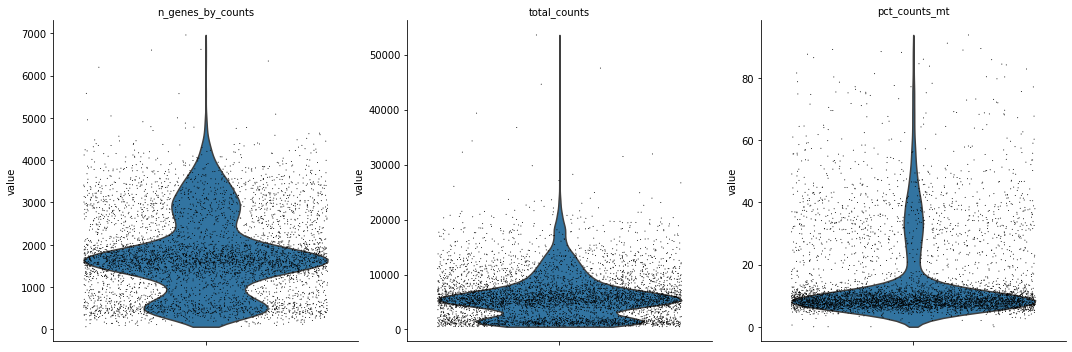

In [ ]:
mdata["rna"].var["mt"] = mdata["rna"].var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(mdata["rna"], qc_vars=["mt"], percent_top=None, log1p=None, inplace=True)
sc.pl.violin(mdata["rna"], ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], jitter=0.4, multi_panel=True)

Filter genes which expression is not detected:

In [ ]:
mu.pp.filter_var(mdata["rna"], 'n_cells_by_counts', lambda x: x >= 3)

Filter cells:

In [ ]:
mu.pp.filter_obs(mdata["rna"], 'n_genes_by_counts', lambda x: (x >= 200) & (x < 5000))
mu.pp.filter_obs(mdata["rna"], 'total_counts', lambda x: (x > 1500) & (x < 15000))
mu.pp.filter_obs(mdata["rna"], 'pct_counts_mt', lambda x: x < 20)

Let’s see how the data looks after filtering:

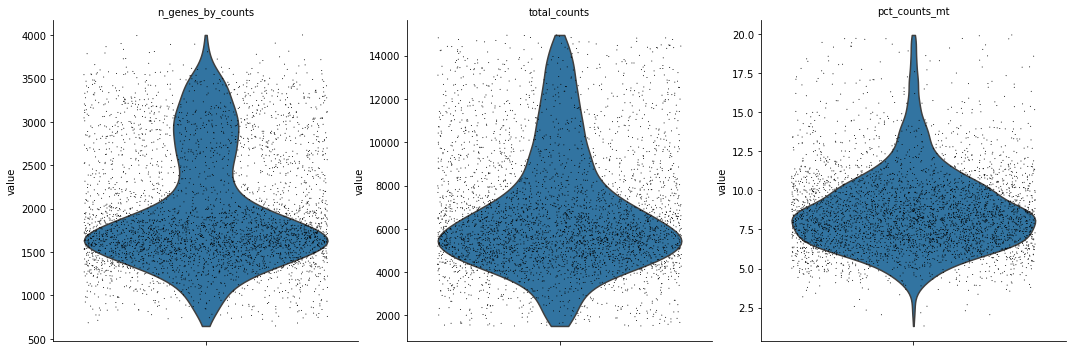

In [ ]:
sc.pl.violin(mdata["rna"], ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], jitter=0.4, multi_panel=True)

Many methods require normalized and log-transformed counts. We save the raw counts in a new layer before normalizing and transforming the `.X` matrix.

In [ ]:
mdata["rna"].layers["counts"] = mdata["rna"].X.copy()
sc.pp.normalize_total(mdata["rna"], target_sum=1e4)
sc.pp.log1p(mdata["rna"])

We can now select highly variable genes that will be used for downstream analysis.

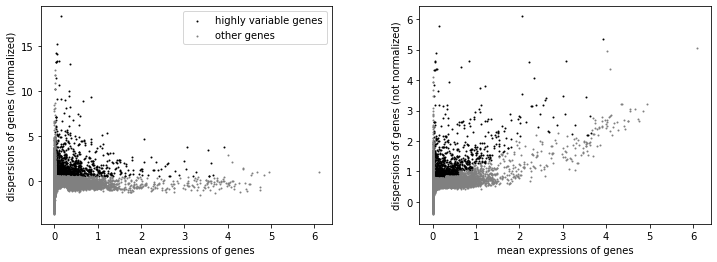

In [ ]:
sc.pp.highly_variable_genes(mdata["rna"], min_mean=0.02, max_mean=4, min_disp=0.5)
sc.pl.highly_variable_genes(mdata["rna"])

We can now run some analyses. For example, we can run a PCA and plot expression of immune cell markers to see if cell types are separated by PCA.

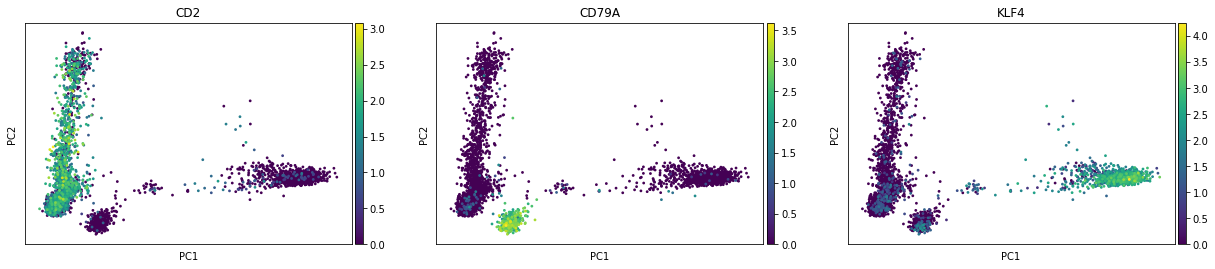

In [ ]:
sc.tl.pca(mdata["rna"])
sc.pl.pca(mdata["rna"], color=['CD2', 'CD79A', 'KLF4'])

We can also check how much variance is captured by the individual PCs.

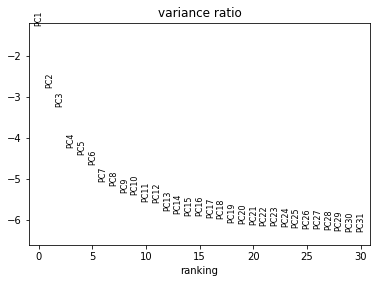

In [ ]:
sc.pl.pca_variance_ratio(mdata["rna"], log=True)

Finally, we can create a neighborhood graph based on the first 20 PCs and use it to perform Leiden clustering and UMAP visualization.

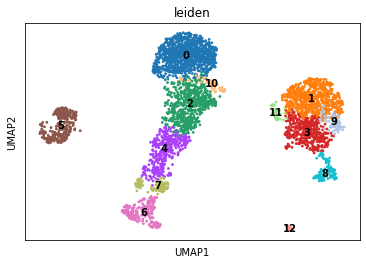

In [ ]:
sc.pp.neighbors(mdata["rna"], n_neighbors=10, n_pcs=20)
sc.tl.leiden(mdata["rna"], resolution=0.75)
sc.tl.umap(mdata["rna"])
sc.pl.umap(mdata["rna"], color="leiden", legend_loc="on data")

Using muon, we can plot the UMAP from the RNA modality, but color it by a variable from another modality.

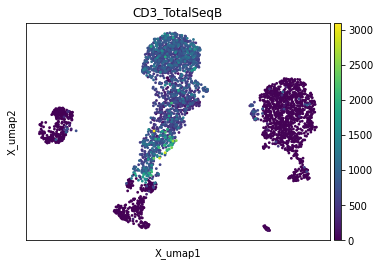

In [ ]:
mu.pl.embedding(mdata, basis="rna:X_umap", color=["CD3_TotalSeqB"])

We can save our MuData object to disk. This will retain all computed quantities, such as the neighborhood graph and cluster assignment. To save some space, we compress the data.

In [ ]:
mdata.write_h5mu("pbmc5k.h5mu", compression="gzip", compression_opts=9)

## Reading a modality from `.h5mu`

Because individual modalities are independent, they can be also fetched from `.h5mu` files as AnnData objects.

In [2]:
# Q: From the .h5mu file you saved in the previous step, read only the protein modality into an AnnData object.
# Hint: This does not involve reading the entire file into MuData and extracting the protein modality.
# prot = mudata.read_h5mu(...)

# Exercises
1. Try to reproduce the cell type annotation part of the [muon tutorial](https://muon-tutorials.readthedocs.io/en/latest/cite-seq/1-CITE-seq-PBMC-5k.html).
2. The above tutorial stores cell type annotation in the RNA modality. But a cell type does not depend on the modality. Move the cell type annotation from the RNA modality to the global MuData object. Hint: you may need to read up on `MuData.update()`.
3. Repeat the Leiden clustering with different settings. Save the results of all clusterings in the same object and plot them.
4. Write the RNA data to disk in a format than can be read by someone only familiar with scanpy/AnnData.